In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [48]:
data = pd.read_csv('SMSSpamCollection', sep = '\t', header = None)
data.columns = ['Label', 'Message']
data.head(10)

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [49]:
print(data.shape)

(5572, 2)


In [50]:
def get_wordnet_pos(tag):
  if tag.startswith('J'):
    return 'a'
  elif tag.startswith('V'):
    return 'v'
  elif tag.startswith('N'):
    return 'n'
  elif tag.startswith('R'):
    return 'r'
  else:
    return 'n'

english_vocab = set(w.lower() for w in nltk.corpus.words.words())

data_np = data.to_numpy()
data_normalized = []
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()
all_words = []
i = 0
for row in data_np:
  target = row[0]
  message = row[1]
  message_lower = message.lower()
  message_lower = re.sub(r'\W', ' ', message_lower)
  message_lower = re.sub(r'\s+', ' ', message_lower)
  words = nltk.word_tokenize(message_lower)
  message_pos_tokens = nltk.pos_tag(words)
  words_without_stopwords = []
  for word, tag in message_pos_tokens:
    if(word not in stop_words and word in english_vocab):
      # TODO: Add some logic to fix spellings/accronyms etc
      word_lemmatized = lemmatizer.lemmatize(word, get_wordnet_pos(tag))
      words_without_stopwords.append(word_lemmatized)
      all_words.append(word_lemmatized)
  message_normzalized = " ".join(words_without_stopwords)
  data_normalized.append([target, message_normzalized])
words_set = set(all_words)
vocab_size = len(words_set)
print(vocab_size)

3608


In [51]:
# Deciding length of words to create features later
message_length_count = {}
spam_message_length_count = {}
for data in data_normalized:
  if(data[0] == 'spam'):
    spam_message = data[1]
    spam_message_words = spam_message.split()
    spam_word_count = len(spam_message_words)
    if(spam_word_count in spam_message_length_count):
      spam_message_length_count[spam_word_count] += 1
    else:
      spam_message_length_count[spam_word_count] = 1

  message = data[1]
  message_words = message.split()
  word_count = len(message_words)
  if(word_count in message_length_count):
    message_length_count[word_count] += 1
  else:
    message_length_count[word_count] = 1

# Find mode
message_length_mode = 0
message_length_highest_count = 0
for item in message_length_count:
  if(message_length_count[item] > message_length_highest_count):
    message_length_mode = item
    message_length_highest_count = message_length_count[item]
print(message_length_mode)
print(message_length_highest_count)

3
806


Text(0.5, 1.0, 'Message length and their counts')

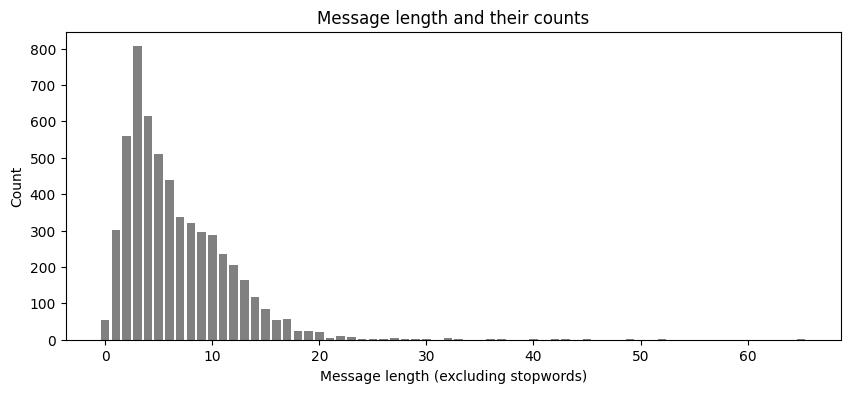

In [52]:
plt.figure(figsize = (10, 4))
plt.bar([item for item in message_length_count], [message_length_count[item] for item in message_length_count], color = 'grey')
plt.xlabel('Message length (excluding stopwords)')
plt.ylabel('Count')
plt.title('Message length and their counts')

Text(0.5, 1.0, 'Spam Message length and their counts')

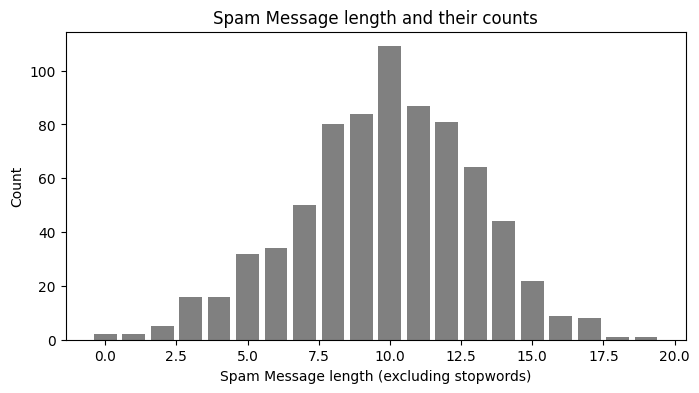

In [53]:
plt.figure(figsize = (8, 4))
plt.bar([item for item in spam_message_length_count], [spam_message_length_count[item] for item in spam_message_length_count], color = 'grey')
plt.xlabel('Spam Message length (excluding stopwords)')
plt.ylabel('Count')
plt.title('Spam Message length and their counts')

Looks like message length of 10 words is the most frequent among spam messages.

In [54]:
data_messages = [data[1] for data in data_normalized]
data_labels = [data[0] for data in data_normalized]
X_train, X_test, y_train, y_test = train_test_split(data_messages, data_labels, test_size = 0.3)

In [55]:
one_hot_map = {}
for i, word in enumerate(words_set):
  one_hot_map[word] = np.zeros(vocab_size)
  one_hot_map[word][i] = 1

window_size = 3
context_size_half = int((window_size - 1) / 2)
embedding_size = 15
features = []
target = []

for message in X_train:
  words = nltk.word_tokenize(message)
  for i in range(context_size_half, len(words) - context_size_half):
    target.append(one_hot_map[words[i]])
    feature = []
    for k in range(1, context_size_half + 1):
      feature.append(one_hot_map[words[i - k]])
      feature.append(one_hot_map[words[i + k]])
    features.append(feature)

def build_nn(features, target, hidden_units, vector_size):
  input1 = tf.keras.Input(shape = (vector_size,), name = 'input1')
  input2 = tf.keras.Input(shape = (vector_size,), name = 'input2')
  shared_embed = tf.keras.layers.Dense(hidden_units, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05), name = "embedded_layer")
  h1 = shared_embed(input1)
  h2 = shared_embed(input2)
  h = tf.keras.layers.Lambda(lambda z: (z[0] + z[1]) / 2.0)([h1, h2])
  output = tf.keras.layers.Dense(vector_size, activation='linear', name='output')(h)
  model = tf.keras.Model(inputs=[input1, input2], outputs=output)
  return model

model = build_nn(features, target, hidden_units=embedding_size, vector_size = vocab_size)
print(model.summary())

best_model_filepath = './best_model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = best_model_filepath,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    verbose = 1
)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

feature1 = np.array([feature_i[0] for feature_i in features])
feature2 = np.array([feature_i[1] for feature_i in features])
target_np = np.array(target)
history = model.fit([feature1, feature2], target_np, epochs = 20, validation_split=0.1, callbacks = [model_checkpoint_callback])

best_model = tf.keras.models.load_model(best_model_filepath, safe_mode=False)
best_model_weights = np.array(best_model.get_layer("embedded_layer").get_weights()[0])

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 3608)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 3608)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedded_layer      │ (None, 15)        │     54,135 │ input1[0][0],     │
│ (Dense)             │                   │            │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 15)        │          0 │ embedded_layer[0… │
│                     │                   │            │ embedded_layer[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 3608)      │     57,728 │ lambda_4[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 111,863 (436.96 KB)

 Trainable params: 111,863 (436.96 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
515/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0245 - loss: 8.9228
Epoch 1: val_loss improved from inf to 8.12737, saving model to ./best_model.keras
520/520 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.0246 - loss: 8.9182 - val_accuracy: 0.0362 - val_loss: 8.1274
Epoch 2/20
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0387 - loss: 8.0757
Epoch 2: val_loss improved from 8.12737 to 7.95119, saving model to ./best_model.keras
520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0387 - loss: 8.0752 - val_accuracy: 0.0362 - val_loss: 7.9512
Epoch 3/20
519/520 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0385 - loss: 7.8781
Epoch 3: val_loss improved from 7.95119 to 7.76141, saving model to ./best_model.keras
520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0385 - loss: 7.8779 - val_accuracy: 0.0362 - val_loss: 7.7614
Epoch 4/20
513/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0374 - loss: 7.6639
Epoch 4: val_loss improved from 7.76141 to

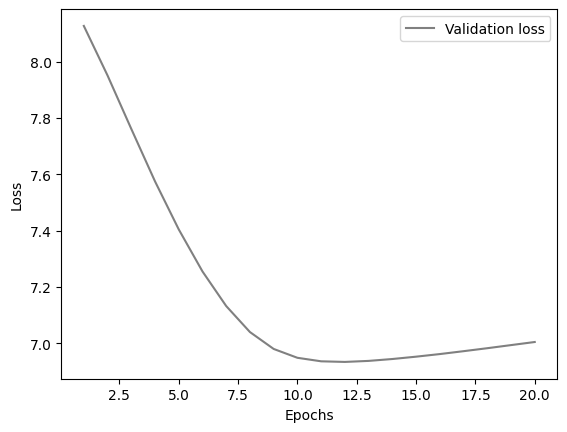

In [56]:
# Plotting validation loss over the epochs
val_loss = history.history['val_loss']
epochs = range(1, len(val_loss) + 1)
plt.plot(epochs, val_loss, color = 'grey', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [57]:
# Get word embeddings from weights
word_embeddings = {}
for word in one_hot_map:
  one_hot_word = one_hot_map[word]
  embedded_word = np.dot(best_model_weights.T, one_hot_word)
  word_embeddings[word] = embedded_word
print(word_embeddings)

{'alone': array([3.01200798e-05, 2.21185310e-05, 2.44253351e-05, 2.25417571e-05,
       3.48866015e-05, 6.81926176e-05, 6.58052886e-05, 4.24953578e-05,
       7.51578555e-05, 3.41720515e-05, 3.01747168e-05, 8.57722116e-05,
       7.59490922e-06, 6.00400490e-05, 4.80055387e-05]), 'top': array([-0.00019891, -0.00032213, -0.00035061, -0.00036934, -0.00023996,
       -0.00027282, -0.00033051, -0.00029688, -0.00023492, -0.00038632,
       -0.00041779, -0.00040842, -0.0002854 , -0.00027416, -0.0003115 ]), 'giggle': array([-1.63986115e-04, -1.82591699e-04, -1.43834739e-04, -1.87864916e-05,
       -2.88378360e-04,  5.96398386e-05, -1.02062710e-04, -2.05197313e-04,
       -2.40733716e-04,  8.04038282e-05, -2.26234610e-04, -2.35634085e-04,
        2.43626710e-05,  5.62491405e-05, -6.53989337e-05]), 'hostel': array([-7.47733850e-07, -2.23113446e-07, -9.95755123e-09,  1.91184739e-07,
       -6.61966226e-07, -6.02563830e-07, -6.53388724e-07, -6.77992659e-07,
       -8.05671675e-07, -4.34082267e-07,

In [58]:
feature_words = []
target_labels = []
for i in range(len(X_train)):
  message = X_train[i]
  target_labels.append(y_train[i])
  words = message.split()
  message_length = len(words)
  words_needed = []
  if(message_length >= 10):
    words_needed = words[:10]
  else:
    words_needed = words
    remaining_words = 10 - len(words)
    for j in range(remaining_words):
      words_needed.append('')
  feature_words.append(words_needed)
print(feature_words)
print(target_labels)

[['urgent', 'mobile', 'number', 'prize', 'call', 'land', 'line', 'claim', 'valid', ''], ['get', 'ta', '', '', '', '', '', '', '', ''], ['day', 'kickoff', 'u', 'keep', 'inform', 'late', 'news', 'daily', 'send', 'get'], ['anyone', 'treadmill', 'say', 'buy', 'make', 'sure', 'working', 'find', 'ad', 'selling'], ['happen', '', '', '', '', '', '', '', '', ''], ['consider', '', '', '', '', '', '', '', '', ''], ['captain', 'comedy', 'captain', 'drunken', '', '', '', '', '', ''], ['get', 'door', '', '', '', '', '', '', '', ''], ['free', 'video', 'camera', 'half', 'price', 'line', 'rental', 'cross', 'call', ''], ['registered', 'subscriber', 'ur', 'draw', 'gift', 'voucher', 'receipt', 'correct', 'whats', ''], ['ok', '', '', '', '', '', '', '', '', ''], ['wed', 'aha', '', '', '', '', '', '', '', ''], ['hard', 'live', 'chat', 'min', 'choose', 'girl', 'connect', 'live', 'call', 'cheap'], ['cant', 'pick', 'phone', 'right', 'send', 'message', '', '', '', ''], ['ur', 'paper', '', '', '', '', '', '', ''

In [59]:
feature_embedded_words = []
target_encoded = []

for i in range(len(feature_words)):
  message_words = feature_words[i]
  message_words_embedded = []
  label = 1 if target_labels[i] == 'spam' else 0
  target_encoded.append(label)
  for word in message_words:
    if(word == ''):
      word_embedded = np.zeros(embedding_size)
    else:
      word_embedded = word_embeddings[word]
    message_words_embedded.append(word_embedded)
  feature_embedded_words.append(message_words_embedded)

print(feature_embedded_words[:3])
print(target_encoded[:3])

[[array([3.04724555e-04, 9.68132808e-05, 3.61954153e-04, 5.14946529e-04,
       1.23631457e-04, 2.81406828e-04, 4.20860684e-04, 3.18016740e-04,
       2.45932752e-04, 3.70135531e-04, 3.13809927e-04, 4.14971088e-04,
       1.14578412e-04, 3.76458222e-04, 1.46599501e-04]), array([0.00187129, 0.00168076, 0.00171701, 0.0019006 , 0.00156373,
       0.00169137, 0.00196101, 0.00163341, 0.00184316, 0.00176902,
       0.00189564, 0.00220572, 0.0018679 , 0.00195545, 0.00165172]), array([0.00113887, 0.00116345, 0.0011999 , 0.00096362, 0.00121221,
       0.00116369, 0.0011582 , 0.00096846, 0.00109428, 0.00095385,
       0.00104055, 0.00111899, 0.00100196, 0.00122593, 0.00096642]), array([0.00237638, 0.00197866, 0.00212072, 0.00238643, 0.00228636,
       0.00241101, 0.00255839, 0.00259541, 0.00262188, 0.00244148,
       0.00224271, 0.00244491, 0.00229875, 0.00271066, 0.00250288]), array([0.00647098, 0.00724319, 0.00641961, 0.00640933, 0.00633163,
       0.00703315, 0.00680248, 0.00674918, 0.0066645